In [1]:
% install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
% load_ext autotime

Installed autotime.py. To use it, type:
  %load_ext autotime


/home/dmitry/Software/anaconda3/envs/a3-dt1/lib/python3.5/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import xgboost as xgb
from numba import vectorize

time: 815 ms


In [3]:
import gc

time: 546 µs


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import pylab
# print (pylab.rcParams.keys())
pylab.rcParams['figure.figsize'] = (18.0, 8.0)
pylab.rcParams['figure.facecolor'] = "white"
pylab.rcParams['axes.facecolor'] = "white"
pylab.rcParams['font.family'] = "sans"

import matplotlib
matplotlib.style.use('ggplot') # temporary for incompatibility of pandas with matplotlib
# pd.options.display.mpl_style = 'default'

pd.set_option('display.max_rows', 20)

time: 191 ms


In [5]:
# data = pd.read_csv('../../data/data.csv', parse_dates=['date'],
#                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
# customers_gender = pd.read_csv('../../../../data/customers_gender_train.csv')
mod_data = pd.read_csv('data.csv', parse_dates=['date'], 
                   date_parser=(
        lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
customers_gender = pd.read_csv('customers_gender_train.csv')

# test_customers = set(data.customer_id.unique().tolist())\
#     .difference(customers_gender.customer_id.unique())

time: 5.13 s


In [6]:
mod_data.head()

,customer_id,mcc_code,amount,date,dateDay,dateWday,dateWeek,dateMonth,dateYear,dateDayOfYear,dateQuarter
0,39026145,4814,-2245.92,2014-08-01,1,4,31,8,2014,213,3
1,39026145,6011,56147.89,2014-08-02,2,5,31,8,2014,214,3
2,39026145,4829,-56147.89,2014-08-02,2,5,31,8,2014,214,3
3,39026145,5499,-1392.47,2014-08-02,2,5,31,8,2014,214,3
4,39026145,5499,-920.83,2014-08-03,3,6,31,8,2014,215,3


time: 11.6 ms


In [7]:
# raw_data = pd.read_csv('../data/transactions.csv')

time: 420 µs


In [8]:
# raw_data.head()

time: 325 µs


In [9]:
mod_data['sign'] = np.sign(mod_data.amount)
idx = (mod_data.sign == 1)
mod_data.loc[idx, 'mcc_code'] = mod_data.loc[idx, 'mcc_code'] * 10 + 1
mod_data.loc[~idx, 'mcc_code'] = mod_data.loc[~idx, 'mcc_code'] * 10

time: 729 ms


In [10]:
mod_data.amount = np.abs(mod_data.amount)

time: 31 ms


In [11]:
mod_data.head()

,customer_id,mcc_code,amount,date,dateDay,dateWday,dateWeek,dateMonth,dateYear,dateDayOfYear,dateQuarter,sign
0,39026145,48140,2245.92,2014-08-01,1,4,31,8,2014,213,3,-1
1,39026145,60111,56147.89,2014-08-02,2,5,31,8,2014,214,3,1
2,39026145,48290,56147.89,2014-08-02,2,5,31,8,2014,214,3,-1
3,39026145,54990,1392.47,2014-08-02,2,5,31,8,2014,214,3,-1
4,39026145,54990,920.83,2014-08-03,3,6,31,8,2014,215,3,-1


time: 10.1 ms


In [12]:
len(mod_data.customer_id.unique())

15000

time: 35.9 ms


In [13]:
def create_date_pivot(df):
    
    date_char = df[['dateYear', 'dateMonth', 
                  'dateWday', 'date']].drop_duplicates().groupby(['dateYear', 
                                                                  'dateMonth', 
                                                                  'dateWday']).size().reset_index()
    date_char.columns = ['dateYear', 'dateMonth', 'dateWday', 'count']
    
    pivot = pd.pivot_table(date_char, 
               values='count', 
               index=['dateYear', 'dateMonth'], 
               columns=['dateWday'])
    pivot.columns = ['Wday_{}'.format(i) for i in pivot.columns]
    pivot.reset_index(inplace=True)
    new_record = pd.DataFrame([[2015,11,5,4,4,4,4,4,5]],columns=pivot.columns)
    pivot = pivot.append(new_record).reset_index(drop=True)
    
    
    return pivot

@vectorize('int64(int64, int64)', target='parallel')
def r_year(value, shift):
    if (value + shift) % 12 == 0:
        return (value + shift) // 12 - 1
    return (value + shift) // 12

@vectorize('int64(int64, int64)', target='parallel')
def r_month(value, shift):
    if (value + shift) % 12 == 0:
        return 12
    return (value + shift) % 12

time: 127 ms


In [14]:
class Context(object):
    test = 1
    play = 1
    income = 1
    test_month = lambda Self: 11 if Self.test else 10
    months = lambda Self: 15 if Self.test else 14
    max_cuses = lambda Self: 10000000 if not Self.play else 5000

cxt = Context()

time: 4.91 ms


In [15]:
cxt.test = 0
cxt.test, cxt.test_month()

(0, 10)

time: 1.42 ms


In [16]:
cxt.play = 0
cxt.play, cxt.max_cuses()

(0, 10000000)

time: 1.32 ms


In [17]:
cxt.income = 1
cxt.income

1

time: 1.09 ms


In [18]:
date_pivot = create_date_pivot(mod_data)

time: 326 ms


In [19]:
date_pivot

,dateYear,dateMonth,Wday_0,Wday_1,Wday_2,Wday_3,Wday_4,Wday_5,Wday_6
0,2014,8,4,4,4,4,5,5,5
1,2014,9,5,5,4,4,4,4,4
2,2014,10,4,4,5,5,5,4,4
3,2014,11,4,4,4,4,4,5,5
4,2014,12,5,5,5,4,4,4,4
5,2015,1,4,4,4,5,5,5,4
6,2015,2,4,4,4,4,4,4,4
7,2015,3,5,5,4,4,4,4,5
8,2015,4,4,4,5,5,4,4,4
9,2015,5,4,4,4,4,5,5,5


time: 10.9 ms


In [20]:
# cuses_test = list(set(data.customer_id.unique().tolist())\
#                   .difference(customers_gender.customer_id.unique()))
# all_cuses = data.customer_id.unique()
all_cuses = mod_data.customer_id.unique()[: cxt.max_cuses()]
cuses_test = list(set(all_cuses.tolist())\
                  .difference(customers_gender.customer_id.unique())) if cxt.test else all_cuses

time: 36.5 ms


In [21]:
len(set(all_cuses) | set(cuses_test))

15000

time: 7.01 ms


In [22]:
# len(cuses_test)
len(all_cuses), len(cuses_test)

(15000, 15000)

time: 1.22 ms


In [23]:
# data = data[data.amount < 0]
data = mod_data if cxt.income else mod_data.query('sign == -1')
data = data.groupby(['customer_id', 'mcc_code', 'dateYear', 'dateMonth'])['amount'].sum().reset_index()

time: 800 ms


In [24]:
data.head()

,customer_id,mcc_code,dateYear,dateMonth,amount
0,6815,48140,2014,8,8983.68
1,6815,48140,2014,9,15721.44
2,6815,48140,2014,10,17967.36
3,6815,48140,2014,11,11229.60
4,6815,48140,2014,12,24705.10


time: 5.87 ms


In [25]:
all_mcc = data.mcc_code.unique()
len(all_mcc)

329

time: 8.02 ms


In [26]:
# train_grid = \
#             pd.DataFrame({'customer_id' : list(np.repeat(data.customer_id.unique(), len(data.mcc_code.unique()))) * 15,
#               'mcc_code' : list(data.mcc_code.unique()) * len(data.customer_id.unique()) * 15,
#               'dateYear' : [2014] *len(data.mcc_code.unique()) * len(data.customer_id.unique()) * 5 + 
#                              [2015] * len(data.mcc_code.unique()) * len(data.customer_id.unique()) * 10,
#               'dateMonth' : list(np.repeat(np.arange(8,13), len(data.mcc_code.unique()) * len(data.customer_id.unique()))) +
#                             list(np.repeat(np.arange(1,11), len(data.mcc_code.unique()) * len(data.customer_id.unique())))})
train_grid = \
            pd.DataFrame({'customer_id' : list(np.repeat(all_cuses, len(all_mcc))) * cxt.months(),
              'mcc_code' : list(all_mcc) * len(all_cuses) * cxt.months(),
              'dateYear' : [2014] *len(all_mcc) * len(all_cuses) * 5 + 
                             [2015] * len(all_mcc) * len(all_cuses) * (cxt.test_month() - 1),
              'dateMonth' : list(np.repeat(np.arange(8,13), len(all_mcc) * len(all_cuses))) +
                            list(np.repeat(np.arange(1,cxt.test_month()), len(all_mcc) * len(all_cuses)))})

time: 37.6 s


In [27]:
train_grid.head()

,customer_id,dateMonth,dateYear,mcc_code
0,39026145,8,2014,48140
1,39026145,8,2014,53110
2,39026145,8,2014,54110
3,39026145,8,2014,59210
4,39026145,8,2014,60101


time: 4.87 ms


In [28]:
train_transactions = \
    pd.merge(train_grid[['customer_id', 'mcc_code', 'dateYear', 'dateMonth']],
             data,
             how='left').fillna(0)

time: 10.2 s


In [29]:
train_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount
0,39026145,48140,2014,8,26277.25
1,39026145,53110,2014,8,0.00
2,39026145,54110,2014,8,561.48
3,39026145,59210,2014,8,0.00
4,39026145,60101,2014,8,224591.58


time: 6.53 ms


In [30]:
test_transactions = \
    pd.DataFrame(columns=cuses_test,
                 index=all_mcc)
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)
test_transactions.columns = ['customer_id', 'mcc_code']

time: 1.33 s


In [31]:
test_transactions.head()

,customer_id,mcc_code
0,39026145,48140
1,39026145,53110
2,39026145,54110
3,39026145,59210
4,39026145,60101


time: 3.74 ms


In [32]:
test_transactions['dateYear'] = 2015
test_transactions['dateMonth'] = cxt.test_month()
test_transactions = pd.merge(test_transactions, data, how='left').fillna(0)

time: 1.22 s


In [33]:
test_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount
0,39026145,48140,2015,10,42672.41
1,39026145,53110,2015,10,0.00
2,39026145,54110,2015,10,0.00
3,39026145,59210,2015,10,0.00
4,39026145,60101,2015,10,0.00


time: 5.63 ms


In [34]:
test_transactions.columns, train_transactions.columns

(Index(['customer_id', 'mcc_code', 'dateYear', 'dateMonth', 'amount'], dtype='object'),
 Index(['customer_id', 'mcc_code', 'dateYear', 'dateMonth', 'amount'], dtype='object'))

time: 1.47 ms


In [35]:
default = train_transactions.copy()
l_d = len(default)

time: 643 ms


In [36]:
l_d

69090000

time: 978 µs


In [37]:
# train_transactions = train_transactions.loc[(train_transactions.dateYear == 2015) & 
#                                                          (train_transactions.dateMonth > 9)]
train_transactions = train_transactions.loc[(train_transactions.dateYear == 2015) & 
                                                         (train_transactions.dateMonth == cxt.test_month() - 1)]

time: 299 ms


In [38]:
train_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount
64155000,39026145,48140,2015,9,24705.11
64155001,39026145,53110,2015,9,0.00
64155002,39026145,54110,2015,9,0.00
64155003,39026145,59210,2015,9,0.00
64155004,39026145,60101,2015,9,44918.32


time: 5.62 ms


In [39]:
for month_shift in range(1, cxt.months()):
#     print month_shift
    print(month_shift)
    train_shift = default.copy()
    train_shift['dateMonth'] = r_month(default['dateMonth'].values, np.array([month_shift]*l_d))
    train_shift['dateYear'] += r_year(default['dateMonth'].values, np.array([month_shift]*l_d))
    train_shift = train_shift.rename(columns={"amount" : 'amount_{0}'.format(month_shift)})  
    train_shift = train_shift[['dateYear', 'dateMonth', 'customer_id', 'mcc_code', 'amount_{0}'.format(month_shift)]]

#     train_transactions = pd.merge(train_transactions, train_shift.loc[(train_shift.dateYear == 2015) & 
#                                                          (train_shift.dateMonth > 9)], 
#                                   on=['dateYear', 'dateMonth', 'customer_id', 'mcc_code'], how='left').fillna(0)
#     test_transactions = pd.merge(test_transactions, train_shift.loc[(train_shift.dateYear == 2015) & 
#                                                          (train_shift.dateMonth > 9)], 
#                                  on=['dateYear', 'dateMonth', 'customer_id', 'mcc_code'], how='left').fillna(0)
    train_transactions = pd.merge(train_transactions, train_shift.loc[(train_shift.dateYear == 2015) & 
                                                         (train_shift.dateMonth == cxt.test_month() - 1)], 
                                  on=['dateYear', 'dateMonth', 'customer_id', 'mcc_code'], how='left').fillna(0)
    test_transactions = pd.merge(test_transactions, train_shift.loc[(train_shift.dateYear == 2015) & 
                                                         (train_shift.dateMonth == cxt.test_month())], 
                                 on=['dateYear', 'dateMonth', 'customer_id', 'mcc_code'], how='left').fillna(0)
    gc.collect()

1
2
3
4
5
6
7
8
9
10
11
12
13
time: 2min 58s


In [40]:
train_shift.head()

,dateYear,dateMonth,customer_id,mcc_code,amount_13
0,2015,9,39026145,48140,26277.25
1,2015,9,39026145,53110,0.00
2,2015,9,39026145,54110,561.48
3,2015,9,39026145,59210,0.00
4,2015,9,39026145,60101,224591.58


time: 5.68 ms


In [41]:
train_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount,amount_1,amount_2,amount_3,amount_4,amount_5,amount_6,amount_7,amount_8,amount_9,amount_10,amount_11,amount_12,amount_13
0,39026145,48140,2015,9,24705.11,32565.81,32565.80,21336.23,58483.68,7860.72,20662.44,17967.34,9994.34,17967.35,24390.65,20213.24,17810.13,26277.25
1,39026145,53110,2015,9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,39026145,54110,2015,9,0.00,125119.98,0.00,0.00,7344.14,0.00,0.00,0.00,0.00,3818.06,0.00,0.00,0.00,561.48
3,39026145,59210,2015,9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,39026145,60101,2015,9,44918.32,0.00,67377.47,0.00,0.00,0.00,0.00,0.00,0.00,112295.79,224591.58,101066.21,96574.38,224591.58


time: 15.7 ms


In [42]:
test_transactions.head(10)

,customer_id,mcc_code,dateYear,dateMonth,amount,amount_1,amount_2,amount_3,amount_4,amount_5,amount_6,amount_7,amount_8,amount_9,amount_10,amount_11,amount_12,amount_13
0,39026145,48140,2015,10,42672.41,24705.11,32565.81,32565.80,21336.23,58483.68,7860.72,20662.44,17967.34,9994.34,17967.35,24390.65,20213.24,17810.13
1,39026145,53110,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,39026145,54110,2015,10,0.00,0.00,125119.98,0.00,0.00,7344.14,0.00,0.00,0.00,0.00,3818.06,0.00,0.00,0.00
3,39026145,59210,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,39026145,60101,2015,10,0.00,44918.32,0.00,67377.47,0.00,0.00,0.00,0.00,0.00,0.00,112295.79,224591.58,101066.21,96574.38
5,39026145,60110,2015,10,534527.95,729922.62,2503073.11,653561.50,145984.52,325657.79,586184.01,1772027.54,680512.48,422232.17,928686.18,305444.55,265018.07,720938.96
6,39026145,60111,2015,10,112295.79,0.00,112295.79,247050.73,92082.54,0.00,0.00,33688.74,0.00,69623.39,0.00,72992.27,0.00,89836.64
7,39026145,48290,2015,10,179673.26,78607.06,224591.59,168443.69,0.00,22459.16,0.00,0.00,0.00,0.00,0.00,112295.79,0.00,0.00
8,39026145,53310,2015,10,78809.19,33733.66,134182.24,249364.02,112520.39,64221.97,0.00,1572.14,264950.68,61987.28,8534.48,0.00,3144.28,197853.96
9,39026145,53990,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


time: 18.3 ms


In [43]:
for shift in range(1, cxt.months() - 1):
    train_transactions['diff_{}_{}'.format(shift, shift + 1)] = \
        train_transactions['amount_{}'.format(shift)] - train_transactions['amount_{}'.format(shift + 1)]
    test_transactions['diff_{}_{}'.format(shift, shift + 1)] = \
        test_transactions['amount_{}'.format(shift)] - test_transactions['amount_{}'.format(shift + 1)]

time: 470 ms


In [44]:
train_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount,amount_1,amount_2,amount_3,amount_4,amount_5,...,diff_3_4,diff_4_5,diff_5_6,diff_6_7,diff_7_8,diff_8_9,diff_9_10,diff_10_11,diff_11_12,diff_12_13
0,39026145,48140,2015,9,24705.11,32565.81,32565.80,21336.23,58483.68,7860.72,...,-37147.45,50622.96,-12801.72,2695.1,7973,-7973.01,-6423.30,4177.41,2403.11,-8467.12
1,39026145,53110,2015,9,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0,0.00,0.00,0.00,0.00,0.00
2,39026145,54110,2015,9,0.00,125119.98,0.00,0.00,7344.14,0.00,...,-7344.14,7344.14,0.00,0.0,0,-3818.06,3818.06,0.00,0.00,-561.48
3,39026145,59210,2015,9,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0,0.00,0.00,0.00,0.00,0.00
4,39026145,60101,2015,9,44918.32,0.00,67377.47,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0,-112295.79,-112295.79,123525.37,4491.83,-128017.20


time: 23.4 ms


In [45]:
test_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount,amount_1,amount_2,amount_3,amount_4,amount_5,...,diff_3_4,diff_4_5,diff_5_6,diff_6_7,diff_7_8,diff_8_9,diff_9_10,diff_10_11,diff_11_12,diff_12_13
0,39026145,48140,2015,10,42672.41,24705.11,32565.81,32565.80,21336.23,58483.68,...,11229.57,-37147.45,50622.96,-12801.72,2695.1,7973,-7973.01,-6423.30,4177.41,2403.11
1,39026145,53110,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0,0.00,0.00,0.00,0.00
2,39026145,54110,2015,10,0.00,0.00,125119.98,0.00,0.00,7344.14,...,0.00,-7344.14,7344.14,0.00,0.0,0,-3818.06,3818.06,0.00,0.00
3,39026145,59210,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0,0.00,0.00,0.00,0.00
4,39026145,60101,2015,10,0.00,44918.32,0.00,67377.47,0.00,0.00,...,67377.47,0.00,0.00,0.00,0.0,0,-112295.79,-112295.79,123525.37,4491.83


time: 21.6 ms


In [46]:
#train_transactions = pd.merge(train_transactions.loc[~((train_transactions.dateYear == 2014) 
#                                                       & (train_transactions.dateMonth < 10))], date_pivot, how='left')

# train_transactions = pd.merge(train_transactions.loc[(train_transactions.dateYear == 2015) & 
#                                                          (train_transactions.dateMonth > 9)], date_pivot, how='left')
train_transactions = pd.merge(train_transactions.loc[(train_transactions.dateYear == 2015) & 
                                                     (train_transactions.dateMonth == cxt.test_month() - 1)], 
                              date_pivot, how='left')
test_transactions = pd.merge(test_transactions, date_pivot, how='left')

time: 2.14 s


In [47]:
train_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount,amount_1,amount_2,amount_3,amount_4,amount_5,...,diff_10_11,diff_11_12,diff_12_13,Wday_0,Wday_1,Wday_2,Wday_3,Wday_4,Wday_5,Wday_6
0,39026145,48140,2015,9,24705.11,32565.81,32565.80,21336.23,58483.68,7860.72,...,4177.41,2403.11,-8467.12,4,5,5,4,4,4,4
1,39026145,53110,2015,9,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,4,5,5,4,4,4,4
2,39026145,54110,2015,9,0.00,125119.98,0.00,0.00,7344.14,0.00,...,0.00,0.00,-561.48,4,5,5,4,4,4,4
3,39026145,59210,2015,9,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,4,5,5,4,4,4,4
4,39026145,60101,2015,9,44918.32,0.00,67377.47,0.00,0.00,0.00,...,123525.37,4491.83,-128017.20,4,5,5,4,4,4,4


time: 18.7 ms


In [48]:
test_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount,amount_1,amount_2,amount_3,amount_4,amount_5,...,diff_10_11,diff_11_12,diff_12_13,Wday_0,Wday_1,Wday_2,Wday_3,Wday_4,Wday_5,Wday_6
0,39026145,48140,2015,10,42672.41,24705.11,32565.81,32565.80,21336.23,58483.68,...,-6423.30,4177.41,2403.11,4,4,4,5,5,5,4
1,39026145,53110,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,4,4,4,5,5,5,4
2,39026145,54110,2015,10,0.00,0.00,125119.98,0.00,0.00,7344.14,...,3818.06,0.00,0.00,4,4,4,5,5,5,4
3,39026145,59210,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,4,4,4,5,5,5,4
4,39026145,60101,2015,10,0.00,44918.32,0.00,67377.47,0.00,0.00,...,-112295.79,123525.37,4491.83,4,4,4,5,5,5,4


time: 19.8 ms


In [49]:
amount_cols = ['amount_%s' % str(m) for m in range(cxt.months())]
amount_cols

['amount_0',
 'amount_1',
 'amount_2',
 'amount_3',
 'amount_4',
 'amount_5',
 'amount_6',
 'amount_7',
 'amount_8',
 'amount_9',
 'amount_10',
 'amount_11',
 'amount_12',
 'amount_13']

time: 1.87 ms


In [50]:
train_transactions['total'] = train_transactions[amount_cols[1: ]].sum(axis=1)
test_transactions['total'] = test_transactions[amount_cols[1: ]].sum(axis=1)

time: 1.22 s


In [51]:
train_transactions['months'] = train_transactions[amount_cols[1: ]].apply(lambda x: len([v for v in x if v > 0]), axis=1)
test_transactions['months'] = test_transactions[amount_cols[1: ]].apply(lambda x: len([v for v in x if v > 0]), axis=1)

time: 2min 26s


In [52]:
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

time: 795 µs


In [53]:
def get_reg_by_amounts(amounts):
    if len(amounts) <= 2:
        return 100
    return np.std(amounts) / np.mean(amounts)

time: 1.11 ms


In [54]:
def get_reg_by_intervals(months, mmax):
    if len(months) <= 2:
        return 100
    intervals = np.diff(sorted(months))
    intervals2 = np.diff([-1] + list(sorted(months)) + [mmax])
#     print(intervals2)
    return np.std(intervals) / np.mean(intervals) \
        if np.mean(intervals) >= np.mean(intervals2) else np.std(intervals2) / np.mean(intervals2)

time: 2.46 ms


In [55]:
def get_reg(e, mmax):
    if not len(e) or len(e[0]) <= 2:
        return 0
    ra = get_reg_by_amounts(e[1])
    ri = get_reg_by_intervals(e[0], mmax)
    return (1 - sigmoid(ra + ri)) * 2

time: 1.87 ms


In [56]:
train_transactions['reg_coeff'] = train_transactions[amount_cols[1: ]]\
    .apply(lambda x: get_reg(tuple(zip(*[(k, v) for k, v in enumerate(list(x)) if v > 0])), cxt.months() - 1), axis=1)
test_transactions['reg_coeff'] = test_transactions[amount_cols[1: ]]\
    .apply(lambda x: get_reg(tuple(zip(*[(k, v) for k, v in enumerate(list(x)) if v > 0])), cxt.months() - 1), axis=1)

time: 4min 7s


In [57]:
# train_transactions['reg_by_amounts'] = train_transactions[amount_cols[1: ]]\
#     .apply(lambda x: get_reg_by_amounts([v for v in x if v]), axis=1)
# test_transactions['reg_by_amounts'] = test_transactions[amount_cols[1: ]]\
#     .apply(lambda x: get_reg_by_amounts([v for v in x if v]), axis=1)

time: 651 µs


In [58]:
# train_transactions['reg_by_intervals'] = train_transactions[amount_cols[1: ]]\
#     .apply(lambda x: get_reg_by_intervals([k for k, v in enumerate(list(x)) if v], cxt.months() - 1), axis=1)
# test_transactions['reg_by_intervals'] = test_transactions[amount_cols[1: ]]\
#     .apply(lambda x: get_reg_by_intervals([k for k, v in enumerate(list(x)) if v], cxt.months() - 1), axis=1)

time: 621 µs


In [59]:
train_transactions['is_income'] = train_transactions.mcc_code.astype(str).str.slice(-1).astype(int)
train_transactions['mcc_code1'] = train_transactions.mcc_code
train_transactions['mcc_code'] = train_transactions.mcc_code.astype(str).str.slice(0, -1).astype(int)
test_transactions['is_income'] = test_transactions.mcc_code.astype(str).str.slice(-1).astype(int)
test_transactions['mcc_code1'] = test_transactions.mcc_code
test_transactions['mcc_code'] = test_transactions.mcc_code.astype(str).str.slice(0, -1).astype(int)

time: 41 s


In [60]:
train_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount,amount_1,amount_2,amount_3,amount_4,amount_5,...,Wday_2,Wday_3,Wday_4,Wday_5,Wday_6,total,months,reg_coeff,is_income,mcc_code1
0,39026145,4814,2015,9,24705.11,32565.81,32565.80,21336.23,58483.68,7860.72,...,5,4,4,4,4,308094.98,13,0.747811,0,48140
1,39026145,5311,2015,9,0.00,0.00,0.00,0.00,0.00,0.00,...,5,4,4,4,4,0.00,0,0.000000,0,53110
2,39026145,5411,2015,9,0.00,125119.98,0.00,0.00,7344.14,0.00,...,5,4,4,4,4,136843.66,4,0.298645,0,54110
3,39026145,5921,2015,9,0.00,0.00,0.00,0.00,0.00,0.00,...,5,4,4,4,4,0.00,0,0.000000,0,59210
4,39026145,6010,2015,9,44918.32,0.00,67377.47,0.00,0.00,0.00,...,5,4,4,4,4,826497.01,6,0.350925,1,60101


time: 20.6 ms


In [61]:
test_transactions.head()

,customer_id,mcc_code,dateYear,dateMonth,amount,amount_1,amount_2,amount_3,amount_4,amount_5,...,Wday_2,Wday_3,Wday_4,Wday_5,Wday_6,total,months,reg_coeff,is_income,mcc_code1
0,39026145,4814,2015,10,42672.41,24705.11,32565.81,32565.80,21336.23,58483.68,...,4,5,5,5,4,306522.84,13,0.746938,0,48140
1,39026145,5311,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,4,5,5,5,4,0.00,0,0.000000,0,53110
2,39026145,5411,2015,10,0.00,0.00,125119.98,0.00,0.00,7344.14,...,4,5,5,5,4,136282.18,3,0.367582,0,54110
3,39026145,5921,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,4,5,5,5,4,0.00,0,0.000000,0,59210
4,39026145,6010,2015,10,0.00,44918.32,0.00,67377.47,0.00,0.00,...,4,5,5,5,4,646823.75,6,0.364983,1,60101


time: 19.5 ms


In [62]:
# train_transactions = train_transactions.query('reg_coeff > 0')
# train_transactions = train_transactions.query('total > 0')
# train_transactions_rare = train_transactions.query('months in (1, 2)')
# train_transactions_often = train_transactions.query('months > 2')

time: 791 µs


In [63]:
y_train = train_transactions['amount'].copy()
train_transactions.drop(['amount'], axis=1, inplace=True)
# y_train_rare = train_transactions_rare['amount'].copy()
# train_transactions_rare.drop(['amount'], axis=1, inplace=True)
# y_train_often = train_transactions_often['amount'].copy()
# train_transactions_often.drop(['amount'], axis=1, inplace=True)

y_test = test_transactions['amount'].copy()
test_transactions.drop(['amount'], axis=1, inplace=True)

time: 2.07 s


In [64]:
# train_transactions.drop(['total', 'months'], axis=1, inplace=True)

time: 449 µs


In [65]:
#set params
param = {}
param['objective'] = 'reg:linear'
param['max_depth'] = 7
# param['max_depth'] = 10
param['eta'] = .1
# param['eta'] = .01
param['colsample_bytree'] = 0.7
param['subsample'] = 0.7
# param['silent'] = 1
param['silent'] = 0
# param['eval_metric'] = 'rmse'

param['early_stopping'] = True
# param['booster'] = 'gblinear'

#param['num_parallel_tree'] = 3
plst = list(param.items()) #+ [('eval_metric', 'merror')]
# num_round = 60
num_round = 2000

time: 4.67 ms


In [66]:
xgb_test = xgb.DMatrix( test_transactions[['customer_id', 'mcc_code', 'dateYear', 'dateMonth', 'amount_1', 
                                          'amount_2', 'amount_3', 'amount_4', 'amount_5', 'amount_6', 'amount_7', 
                                          'amount_8', 'amount_9', 'amount_10', 'amount_11', 'amount_12', 
                                          'amount_13', 'diff_1_2', 'diff_2_3', 'diff_3_4', 'diff_4_5', 'diff_5_6', 
                                          'diff_6_7', 'diff_7_8', 'diff_8_9', 'diff_9_10', 'diff_10_11', 
                                          'diff_11_12', 'diff_12_13', 'Wday_0', 'Wday_1', 'Wday_2', 'Wday_3', 
                                          'Wday_4', 'Wday_5', 'Wday_6', 
                                          'total', 'months', 
                                          'reg_coeff', 
                                          'is_income', 'mcc_code1', 
#                                            'reg_by_amounts', 'reg_by_intervals'
                                          ]] , 
                       feature_names=['customer_id', 'mcc_code', 'dateYear', 'dateMonth', 'amount_1', 
                                          'amount_2', 'amount_3', 'amount_4', 'amount_5', 'amount_6', 'amount_7', 
                                          'amount_8', 'amount_9', 'amount_10', 'amount_11', 'amount_12', 
                                          'amount_13', 'diff_1_2', 'diff_2_3', 'diff_3_4', 'diff_4_5', 'diff_5_6', 
                                          'diff_6_7', 'diff_7_8', 'diff_8_9', 'diff_9_10', 'diff_10_11', 
                                          'diff_11_12', 'diff_12_13', 'Wday_0', 'Wday_1', 'Wday_2', 'Wday_3', 
                                          'Wday_4', 'Wday_5', 'Wday_6', 
                                          'total', 'months', 
                                          'reg_coeff', 
                                          'is_income', 'mcc_code1', 
#                                       'reg_by_amounts', 'reg_by_intervals'
                                     ], label = np.log1p(y_test) )

time: 4.4 s


In [67]:
# xgb_train = xgb.DMatrix( train_transactions, label = np.log1p(-y_train), feature_names=train_transactions.columns)
xgb_train = xgb.DMatrix( train_transactions, label = np.log1p(y_train), feature_names=train_transactions.columns)
# xgb_train_rare = xgb.DMatrix( train_transactions_rare, label = np.log1p(y_train_rare), 
#                              feature_names=train_transactions_rare.columns)
# xgb_train_often = xgb.DMatrix( train_transactions_often, label = np.log1p(y_train_often), 
#                               feature_names=train_transactions_often.columns)
# xgb_train = xgb.DMatrix( train_transactions, label = y_train + 1, feature_names=train_transactions.columns)
# xgb_test = xgb.DMatrix( test_transactions, feature_names=test_transactions.columns)

# bst = xgb.train(param, xgb_train, num_round)
watchlist  = [ (xgb_train,'train'),(xgb_test,'eval')]
bst = xgb.train(param, xgb_train, num_boost_round=num_round, evals=watchlist, early_stopping_rounds=30)
# bst = xgb.train(param, xgb_train, num_boost_round=num_round, evals=watchlist)
# bst_rare = xgb.train(param, xgb_train_rare, num_round)
# bst_often = xgb.train(param, xgb_train_often, num_round)

# Stopping. Best iteration:
# [90]	train-rmse:1.00117	eval-rmse:1.03077

[0]	train-rmse:1.55636	eval-rmse:1.58349
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:1.47115	eval-rmse:1.49727
[2]	train-rmse:1.39854	eval-rmse:1.42379
[3]	train-rmse:1.33587	eval-rmse:1.3603
[4]	train-rmse:1.28273	eval-rmse:1.30619
[5]	train-rmse:1.23779	eval-rmse:1.26055
[6]	train-rmse:1.20021	eval-rmse:1.22232
[7]	train-rmse:1.16869	eval-rmse:1.19029
[8]	train-rmse:1.14278	eval-rmse:1.16424
[9]	train-rmse:1.12085	eval-rmse:1.14199
[10]	train-rmse:1.10282	eval-rmse:1.12366
[11]	train-rmse:1.08747	eval-rmse:1.10807
[12]	train-rmse:1.07498	eval-rmse:1.09526
[13]	train-rmse:1.06439	eval-rmse:1.08447
[14]	train-rmse:1.05564	eval-rmse:1.07549
[15]	train-rmse:1.04851	eval-rmse:1.06822
[16]	train-rmse:1.04255	eval-rmse:1.06216
[17]	train-rmse:1.03761	eval-rmse:1.05713
[18]	train-rmse:1.03332	eval-rmse:1.05283
[19]	train-rmse:1.02985	eval-rmse:1.04936
[20]	train-rmse:1.02697	eval

In [68]:
test_transactions['volume'] = np.e ** bst.predict(xgb_test, ntree_limit=bst.best_iteration) - 1
# test_transactions.loc[test_transactions.reg_coeff == 0, 'volume'] = 0
# test_transactions.loc[test_transactions.total == 0, 'volume'] = 0
# test_transactions.loc[test_transactions.months.isin((1, 2)), 'volume'] = np.e ** bst_rare.predict(xgb_test_rare) - 1
# test_transactions.loc[test_transactions.months > 2, 'volume'] = np.e ** bst_often.predict(xgb_test_often) - 1
# test_transactions['volume'] = bst.predict(xgb_test) - 1
# test_transactions[['customer_id', 'mcc_code', 'volume']].to_csv('xgb_with_income.csv', index=False)
test_transactions[['customer_id', 'mcc_code', 'volume']].to_csv('xgb_with_income.val.9.csv')
y_test.to_csv('xgb_with_income.val.truth.csv')
# test_transactions_upd = test_transactions.copy()
# test_transactions_upd['volume'] = np.e ** bst.predict(xgb_test) - 1
# test_transactions_upd[['customer_id', 'mcc_code', 'volume']].to_csv('xgb_with_income.csv', index=False)
# test_transactions_upd[['customer_id', 'mcc_code', 'volume']].to_csv('xgb_with_income.val.csv', index=False)

time: 30.1 s


In [69]:
test_transactions.head(10)

,customer_id,mcc_code,dateYear,dateMonth,amount_1,amount_2,amount_3,amount_4,amount_5,amount_6,...,Wday_3,Wday_4,Wday_5,Wday_6,total,months,reg_coeff,is_income,mcc_code1,volume
0,39026145,4814,2015,10,24705.11,32565.81,32565.80,21336.23,58483.68,7860.72,...,5,5,5,4,306522.84,13,0.746938,0,48140,20307.957031
1,39026145,5311,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,5,5,5,4,0.00,0,0.000000,0,53110,0.086294
2,39026145,5411,2015,10,0.00,125119.98,0.00,0.00,7344.14,0.00,...,5,5,5,4,136282.18,3,0.367582,0,54110,16.535154
3,39026145,5921,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,5,5,5,4,0.00,0,0.000000,0,59210,0.091799
4,39026145,6010,2015,10,44918.32,0.00,67377.47,0.00,0.00,0.00,...,5,5,5,4,646823.75,6,0.364983,1,60101,734.232056
5,39026145,6011,2015,10,729922.62,2503073.11,653561.50,145984.52,325657.79,586184.01,...,5,5,5,4,10039243.50,13,0.609608,0,60110,303197.062500
6,39026145,6011,2015,10,0.00,112295.79,247050.73,92082.54,0.00,0.00,...,5,5,5,4,717570.10,7,0.541348,1,60111,385.461609
7,39026145,4829,2015,10,78607.06,224591.59,168443.69,0.00,22459.16,0.00,...,5,5,5,4,606397.29,5,0.394819,0,48290,6724.145996
8,39026145,5331,2015,10,33733.66,134182.24,249364.02,112520.39,64221.97,0.00,...,5,5,5,4,1132065.10,11,0.450355,0,53310,12692.333984
9,39026145,5399,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,5,5,5,4,0.00,0,0.000000,0,53990,0.086294


time: 24 ms


In [70]:
# test_transactions['volume'] = -test_transactions.amount_1.copy()
# test_transactions[['customer_id', 'mcc_code', 'volume']].to_csv('last_month_minus.csv', index=False)

time: 605 µs


In [71]:
test_transactions['true_volume'] = y_test

time: 10.8 ms


In [72]:
# test_transactions['total'] = test_transactions[amount_cols[1: ]].sum(axis=1)
len(test_transactions.query('total > 0 and is_income == 0'))\
    , len(test_transactions.query('total == 0 and is_income == 0'))

(275412, 2484588)

time: 914 ms


In [86]:
# tt = test_transactions.query('total != 0')
tt = test_transactions.query('is_income == 0')
# tt = test_transactions.query('is_income == 0 and reg_coeff > 0')
# tt = test_transactions

time: 310 ms


In [74]:
# tt['volume2'] = tt.volume

time: 474 µs


In [75]:
# tt.loc[tt.volume < 400, 'volume'] = 0

time: 540 µs


In [76]:
np.sum(tt.true_volume < tt.volume), np.sum(tt.true_volume > tt.volume)

(2668309, 91691)

time: 64.3 ms


In [77]:
np.sum(tt[tt.true_volume < tt.volume].volume - tt[tt.true_volume < tt.volume].true_volume)

1939099755.2308536

time: 442 ms


In [78]:
np.sum(tt[tt.true_volume > tt.volume].true_volume - tt[tt.true_volume > tt.volume].volume)

20422754682.58663

time: 62.3 ms


In [79]:
np.sum(tt.true_volume), np.sum(tt.volume)

(28735989408.920704, 1.0252338e+10)

time: 11.1 ms


In [80]:
np.sum(np.abs(tt.true_volume - tt.volume)) / len(tt.true_volume)

8102.1211731068515

time: 9.96 ms


In [81]:
(np.sum((tt.true_volume - tt.volume) ** 2) / len(tt.true_volume)) ** (1 / 2)

561244.2449532343

time: 52.1 ms


In [87]:
(np.sum((np.log1p(tt.true_volume) - np.log1p(tt.volume)) ** 2) / len(tt.true_volume)) ** (1 / 2)
# 1.2825865116078718 - no positive
# 1.2817053131760676 - no zeros + total, months
# 1.2829658586415258 - no zeros
# 1.2825715195747436 - no zeros + reg_coeff
# 1.2827337728343111 - no zeros + reg_by_amounts, reg_by_intervals
# 1.2815389188304553 - no zeros + total, months, reg_coeff
# 1.281227381028581 - total, months, reg_coeff

# 1.2851011666572503 - with positive
# new params
# 1.2833245666062782 - total, months, reg_coeff
# 1.2819987256804453 - total, months, reg_coeff, is_income, mcc_code1 

1.2819987256804453

time: 90 ms


In [83]:
# tt = tt.query('mcc_code0 in (5541, 5411, 5992, 4816, 7230, 6011, 7832, 8043, 7542, 4814)')
# 2.283801686102071
# tt = tt.query('mcc_code0 in (4814, 6011, 5411, 4829, 5912, 5499, 5541, 5331, 5814, 5812)')
# 3.333225210968468
# tt = tt.query('mcc_code0 in (5211, 4121, 5533, 5964, 6051, 7995, 5732, 5261, 5722, 5251)')
# 1.6693525032144574
# tt = tt.query('mcc_code0 in (2741, 5072, 6513, 8244, 7932, 5044, 9402, 5971, 8699, 5697)')
# 0.18710926397204347

time: 990 µs


In [88]:
tt = test_transactions.query('is_income == 0 and reg_coeff > 0')

time: 64.9 ms


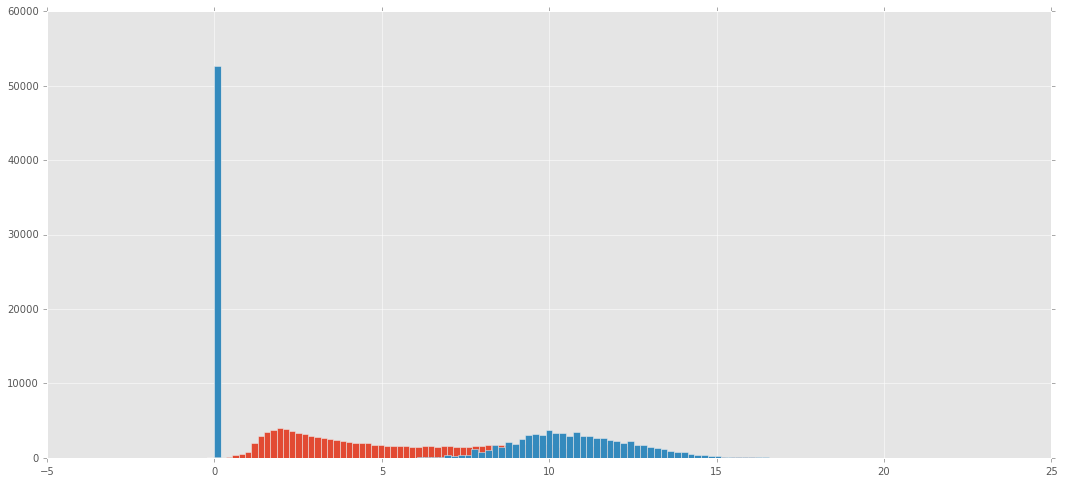

time: 708 ms


In [89]:
np.log1p(tt.volume).hist(bins=100)
np.log1p(tt.true_volume).hist(bins=100)

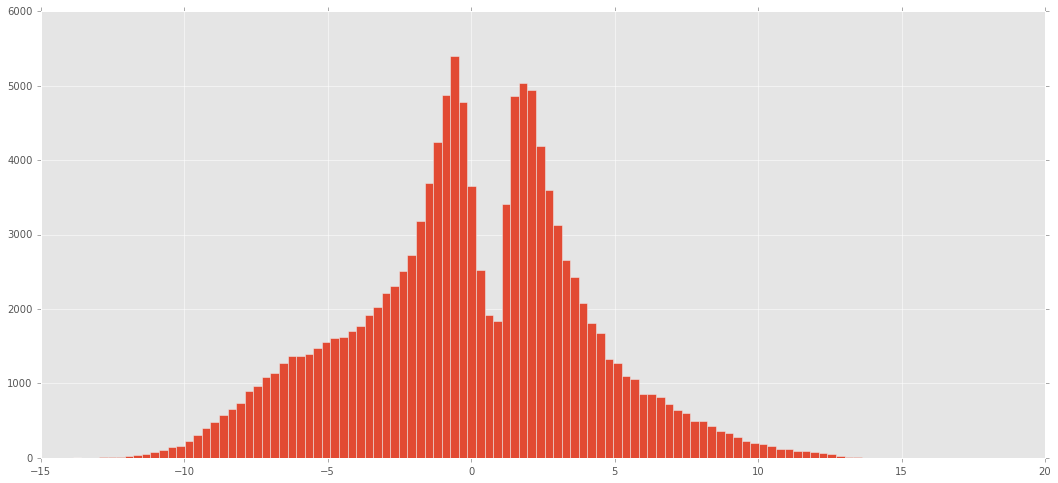

time: 502 ms


In [90]:
(np.log1p(tt.volume) - np.log1p(tt.true_volume)).hist(bins=100)

In [91]:
(sum((np.log1p(tt.volume) - np.log1p(tt.true_volume)) ** 2) / len(tt.true_volume)) ** (1 / 2)

4.0417303975847281

time: 19.7 ms


In [ ]:
############################ Analytics ##########################

In [93]:
tt = test_transactions.query('is_income == 0')

time: 295 ms


In [94]:
tt[amount_cols[1: ] + ['volume', 'true_volume', 'reg_coeff']]

,amount_1,amount_2,amount_3,amount_4,amount_5,amount_6,amount_7,amount_8,amount_9,amount_10,amount_11,amount_12,amount_13,volume,true_volume,reg_coeff
0,24705.11,32565.81,32565.80,21336.23,58483.68,7860.72,20662.44,17967.34,9994.34,17967.35,24390.65,20213.24,17810.13,20307.957031,42672.41,0.746938
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.086294,0.00,0.000000
2,0.00,125119.98,0.00,0.00,7344.14,0.00,0.00,0.00,0.00,3818.06,0.00,0.00,0.00,16.535154,0.00,0.367582
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.091799,0.00,0.000000
5,729922.62,2503073.11,653561.50,145984.52,325657.79,586184.01,1772027.54,680512.48,422232.17,928686.18,305444.55,265018.07,720938.96,303197.062500,534527.95,0.609608
7,78607.06,224591.59,168443.69,0.00,22459.16,0.00,0.00,0.00,0.00,0.00,112295.79,0.00,0.00,6724.145996,179673.26,0.394819
8,33733.66,134182.24,249364.02,112520.39,64221.97,0.00,1572.14,264950.68,61987.28,8534.48,0.00,3144.28,197853.96,12692.333984,78809.19,0.450355
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.086294,0.00,0.000000
10,176552.12,297451.77,204496.45,78202.78,156329.21,25614.67,239822.48,167239.88,30892.57,132412.46,94305.99,40100.82,55294.44,56427.996094,77864.31,0.694801
11,63593.11,130840.34,81347.07,30544.46,131352.41,0.00,76069.19,76080.39,15586.66,58719.47,32049.22,12262.70,45154.13,23468.527344,53565.09,0.592578


time: 91.7 ms


In [95]:
# tr = train_transactions.copy()
tr = test_transactions.copy()
tr['amount_0'] = tr.true_volume
# tr['mcc_code1'] = tr.mcc_code
# tr['is_income'] = tr.mcc_code.astype(str).str.slice(-1).astype(int)
# tr.mcc_code = tr.mcc_code.astype(str).str.slice(0, -1).astype(int)
tr.head()

,customer_id,mcc_code,dateYear,dateMonth,amount_1,amount_2,amount_3,amount_4,amount_5,amount_6,...,Wday_5,Wday_6,total,months,reg_coeff,is_income,mcc_code1,volume,true_volume,amount_0
0,39026145,4814,2015,10,24705.11,32565.81,32565.80,21336.23,58483.68,7860.72,...,5,4,306522.84,13,0.746938,0,48140,20307.957031,42672.41,42672.41
1,39026145,5311,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,5,4,0.00,0,0.000000,0,53110,0.086294,0.00,0.00
2,39026145,5411,2015,10,0.00,125119.98,0.00,0.00,7344.14,0.00,...,5,4,136282.18,3,0.367582,0,54110,16.535154,0.00,0.00
3,39026145,5921,2015,10,0.00,0.00,0.00,0.00,0.00,0.00,...,5,4,0.00,0,0.000000,0,59210,0.091799,0.00,0.00
4,39026145,6010,2015,10,44918.32,0.00,67377.47,0.00,0.00,0.00,...,5,4,646823.75,6,0.364983,1,60101,734.232056,0.00,0.00


time: 419 ms


In [96]:
users = pd.DataFrame(tr.groupby(('customer_id', 'is_income'))[list(set(amount_cols) - {'amount_0'})].sum())\
    .sum(axis=1)\
    .reset_index()\
    .pivot(index='customer_id', columns='is_income', values=0)\
    .rename(columns={0: 'expenses', 1: 'income'})
users['balance'] = users.income - users.expenses
users

is_income,expenses,income,balance
customer_id,,,
6815,3819276.56,236045.75,-3583230.81
22899,5745046.13,5295624.67,-449421.46
27914,2956813.64,404264.90,-2552548.74
28753,59196914.51,39761706.31,-19435208.20
31385,3206317.92,1195186.56,-2011131.36
38084,23079586.16,22070614.40,-1008971.76
42096,13624989.03,9132034.21,-4492954.82
49101,2952442.52,851202.08,-2101240.44
49793,23470891.78,569339.67,-22901552.11


time: 1.07 s


In [97]:
users = users.join(tr.groupby(('customer_id', 'is_income'))['amount_0'].sum()\
    .reset_index()\
    .pivot(index='customer_id', columns='is_income', values='amount_0')\
    .rename(columns={0: 'expenses_new', 1: 'income_new'}))
users['balance_new'] = users.balance - users.expenses_new + users.income_new
users

is_income,expenses,income,balance,expenses_new,income_new,balance_new
customer_id,,,,,,
6815,3819276.56,236045.75,-3583230.81,26681.51,0.00,-3609912.32
22899,5745046.13,5295624.67,-449421.46,470098.26,489609.64,-429910.08
27914,2956813.64,404264.90,-2552548.74,5614.80,5614.80,-2552548.74
28753,59196914.51,39761706.31,-19435208.20,8750368.58,3930352.60,-24255224.18
31385,3206317.92,1195186.56,-2011131.36,22683.75,0.00,-2033815.11
38084,23079586.16,22070614.40,-1008971.76,3836385.77,2909359.29,-1935998.24
42096,13624989.03,9132034.21,-4492954.82,1429331.82,1033121.25,-4889165.39
49101,2952442.52,851202.08,-2101240.44,0.00,0.00,-2101240.44
49793,23470891.78,569339.67,-22901552.11,1583799.15,43795.36,-24441555.90


time: 211 ms


In [98]:
users['NWI'] = 0
users.loc[users.balance != 0, 'NWI'] = (users.balance_new - users.balance) / np.abs(users.balance)
users['sNWI'] = users.NWI.apply(sigmoid)
users

is_income,expenses,income,balance,expenses_new,income_new,balance_new,NWI,sNWI
customer_id,,,,,,,,
6815,3819276.56,236045.75,-3583230.81,26681.51,0.00,-3609912.32,-0.007446,0.498138
22899,5745046.13,5295624.67,-449421.46,470098.26,489609.64,-429910.08,0.043414,0.510852
27914,2956813.64,404264.90,-2552548.74,5614.80,5614.80,-2552548.74,0.000000,0.500000
28753,59196914.51,39761706.31,-19435208.20,8750368.58,3930352.60,-24255224.18,-0.248004,0.438315
31385,3206317.92,1195186.56,-2011131.36,22683.75,0.00,-2033815.11,-0.011279,0.497180
38084,23079586.16,22070614.40,-1008971.76,3836385.77,2909359.29,-1935998.24,-0.918783,0.285206
42096,13624989.03,9132034.21,-4492954.82,1429331.82,1033121.25,-4889165.39,-0.088185,0.477968
49101,2952442.52,851202.08,-2101240.44,0.00,0.00,-2101240.44,0.000000,0.500000
49793,23470891.78,569339.67,-22901552.11,1583799.15,43795.36,-24441555.90,-0.067245,0.483195


time: 73.4 ms


In [99]:
tr['reg_amount_0'] = tr.amount_0 * tr.reg_coeff

time: 23.6 ms


In [114]:
users['reg_expenses'] = tr.query('is_income == 0').groupby('customer_id').reg_amount_0.sum()

time: 323 ms


In [115]:
users['FSI'] = 0
users.loc[users.reg_expenses != 0, 'FSI'] = users.income_new / users.reg_expenses
users['sFSI'] = users.FSI.apply(sigmoid)
users

is_income,expenses,income,balance,expenses_new,income_new,balance_new,NWI,sNWI,reg_expenses,FSI,sFSI,NWI_score,FSI_score,FHI,income_score,expenses_score
customer_id,,,,,,,,,,,,,,,,
6815,3819276.56,236045.75,-3583230.81,26681.51,0.00,-3609912.32,-0.007446,0.498138,16213.155905,0.000000,0.500000,3.869837,0.000333,3.870170,19.066667,21.320000
22899,5745046.13,5295624.67,-449421.46,470098.26,489609.64,-429910.08,0.043414,0.510852,175790.204014,2.785193,0.941870,4.423475,3.579333,8.002809,66.260000,34.446667
27914,2956813.64,404264.90,-2552548.74,5614.80,5614.80,-2552548.74,0.000000,0.500000,2532.455470,2.217137,0.901778,4.000288,4.098000,8.098288,22.466667,15.626667
28753,59196914.51,39761706.31,-19435208.20,8750368.58,3930352.60,-24255224.18,-0.248004,0.438315,3680616.391367,1.067852,0.744188,0.514058,3.180667,3.694724,94.820000,94.980000
31385,3206317.92,1195186.56,-2011131.36,22683.75,0.00,-2033815.11,-0.011279,0.497180,13516.154170,0.000000,0.500000,3.814995,0.000667,3.815661,35.426667,17.246667
38084,23079586.16,22070614.40,-1008971.76,3836385.77,2909359.29,-1935998.24,-0.918783,0.285206,1193499.365648,2.437671,0.919655,0.146130,2.927333,3.073463,90.040000,83.100000
42096,13624989.03,9132034.21,-4492954.82,1429331.82,1033121.25,-4889165.39,-0.088185,0.477968,1059725.842016,0.974895,0.726094,1.737591,1.945000,3.682591,77.480000,67.506667
49101,2952442.52,851202.08,-2101240.44,0.00,0.00,-2101240.44,0.000000,0.500000,0.000000,0.000000,0.500000,4.000575,0.001000,4.001575,30.253333,15.573333
49793,23470891.78,569339.67,-22901552.11,1583799.15,43795.36,-24441555.90,-0.067245,0.483195,575943.074663,0.076041,0.519001,2.531413,4.806667,7.338079,25.666667,83.433333


time: 102 ms


In [129]:
users.loc[users.NWI < 0, 'NWI_score'] = users.loc[users.NWI < 0].NWI.rank(method='average', pct=True) * 4
users.loc[users.NWI >= 0, 'NWI_score'] = users.loc[users.NWI >= 0].NWI.rank(method='average', pct=True) + 4
users['FSI_score'] = users.FSI.rank(method='average', pct=True) * 5
users['FHI'] = users.NWI_score + users.FSI_score
users['income_score'] = users.income.rank(method='average', pct=True) * 100
users['expenses_score'] = users.expenses.rank(method='average', pct=True) * 100
users

is_income,expenses,income,balance,expenses_new,income_new,balance_new,NWI,sNWI,reg_expenses,FSI,sFSI,NWI_score,FSI_score,FHI,income_score,expenses_score
customer_id,,,,,,,,,,,,,,,,
6815,3819276.56,236045.75,-3583230.81,26681.51,0.00,-3609912.32,-0.007446,0.498138,16213.155905,0.000000,0.500000,3.869837,0.743500,4.613337,19.066667,21.320000
22899,5745046.13,5295624.67,-449421.46,470098.26,489609.64,-429910.08,0.043414,0.510852,175790.204014,2.785193,0.941870,4.423475,4.283333,8.706809,66.260000,34.446667
27914,2956813.64,404264.90,-2552548.74,5614.80,5614.80,-2552548.74,0.000000,0.500000,2532.455470,2.217137,0.901778,4.071059,4.004000,8.075059,22.466667,15.626667
28753,59196914.51,39761706.31,-19435208.20,8750368.58,3930352.60,-24255224.18,-0.248004,0.438315,3680616.391367,1.067852,0.744188,0.514058,3.106667,3.620724,94.820000,94.980000
31385,3206317.92,1195186.56,-2011131.36,22683.75,0.00,-2033815.11,-0.011279,0.497180,13516.154170,0.000000,0.500000,3.814995,0.743500,4.558495,35.426667,17.246667
38084,23079586.16,22070614.40,-1008971.76,3836385.77,2909359.29,-1935998.24,-0.918783,0.285206,1193499.365648,2.437671,0.919655,0.146130,4.130333,4.276463,90.040000,83.100000
42096,13624989.03,9132034.21,-4492954.82,1429331.82,1033121.25,-4889165.39,-0.088185,0.477968,1059725.842016,0.974895,0.726094,1.737591,3.030667,4.768258,77.480000,67.506667
49101,2952442.52,851202.08,-2101240.44,0.00,0.00,-2101240.44,0.000000,0.500000,0.000000,0.000000,0.500000,4.071059,0.743500,4.814559,30.256667,15.573333
49793,23470891.78,569339.67,-22901552.11,1583799.15,43795.36,-24441555.90,-0.067245,0.483195,575943.074663,0.076041,0.519001,2.531413,1.681333,4.212746,25.666667,83.433333


time: 38.6 ms


In [130]:
users.describe()

is_income,expenses,income,balance,expenses_new,income_new,balance_new,NWI,sNWI,reg_expenses,FSI,sFSI,NWI_score,FSI_score,FHI,income_score,expenses_score
count,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.996738e+07,1.186306e+07,-8.104322e+06,1.915733e+06,1.229265e+06,-8.790789e+06,-1.694156,0.485303,9.623016e+05,2.612542,0.684738,2.579500,2.500167,5.079667,50.003333,50.003333
std,8.779834e+07,8.207409e+07,2.874407e+07,1.011474e+07,8.432589e+06,3.159665e+07,97.788855,0.100490,4.552028e+06,26.381576,0.183505,1.468481,1.424326,2.399656,28.857617,28.868476
min,0.000000e+00,0.000000e+00,-1.332694e+09,0.000000e+00,0.000000e+00,-1.505430e+09,-7675.027150,0.000000,0.000000e+00,0.000000,0.500000,0.000347,0.743500,0.744541,4.550000,0.103333
25%,4.362114e+06,5.301001e+05,-8.913058e+06,2.874772e+05,0.000000e+00,-9.581655e+06,-0.108794,0.472828,1.187302e+05,0.000000,0.500000,1.301892,0.743500,3.275449,25.005000,25.005000
50%,8.527592e+06,2.556680e+06,-4.196866e+06,6.244196e+05,1.459845e+05,-4.514164e+06,-0.065296,0.483682,3.092675e+05,0.517589,0.626584,2.603436,2.500167,4.613368,50.003333,50.003333
75%,1.699589e+07,8.058886e+06,-9.260248e+05,1.333463e+06,6.400860e+05,-1.016051e+06,-0.004687,0.498828,6.742512e+05,1.815979,0.860083,3.904981,3.750083,6.941138,75.001667,75.001667
max,8.541879e+09,8.542244e+09,5.383638e+08,6.262608e+08,4.328901e+08,6.282929e+08,443.536176,1.000000,2.675595e+08,2026.457375,1.000000,5.000000,5.000000,9.986822,100.000000,100.000000


time: 73.2 ms


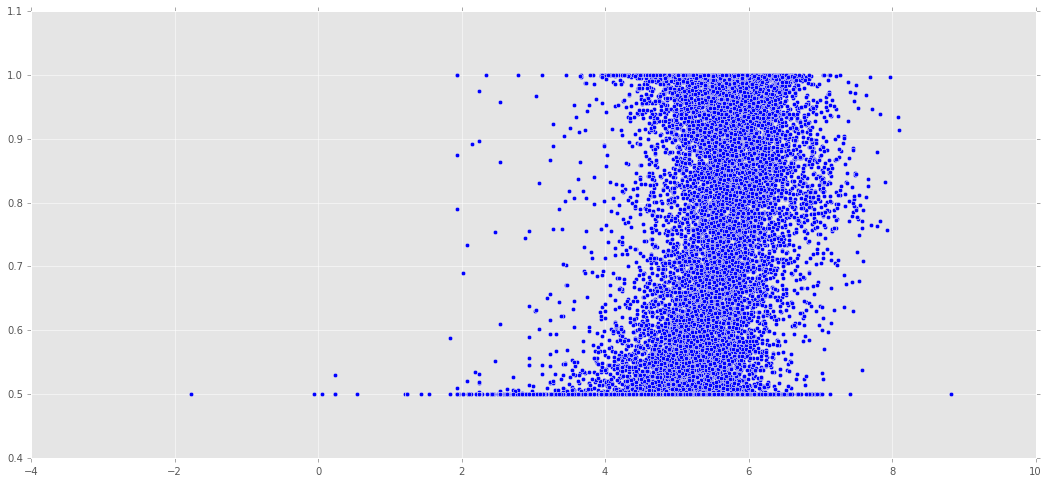

time: 460 ms


In [137]:
plt.scatter(np.log10(users.income / 13), users.sFSI)

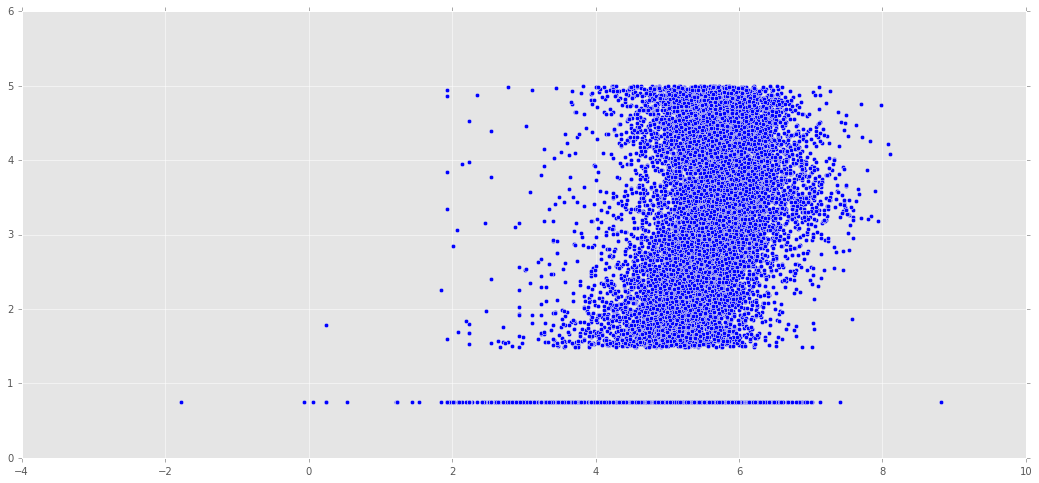

time: 388 ms


In [138]:
plt.scatter(np.log10(users.income / 13), users.FSI_score)

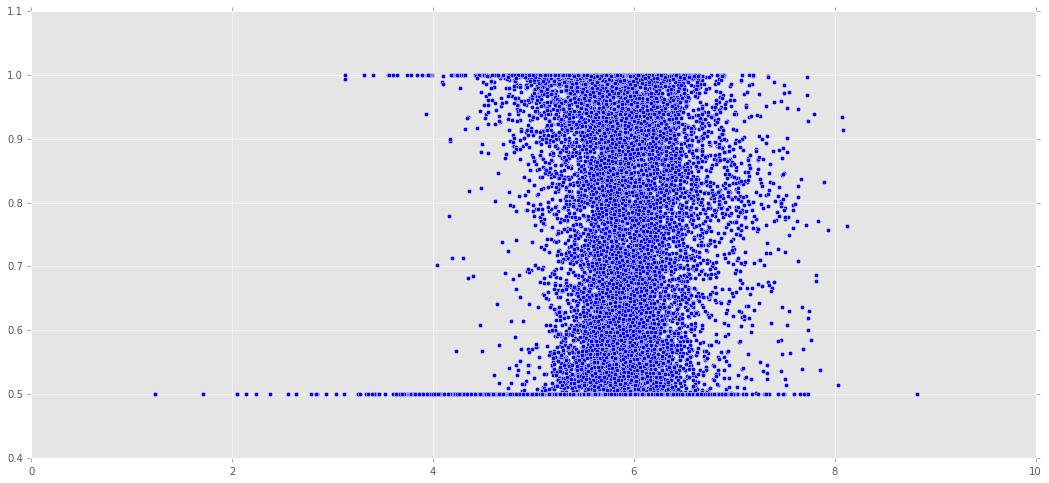

time: 417 ms


In [131]:
plt.scatter(np.log10(users.expenses / 13), users.sFSI)

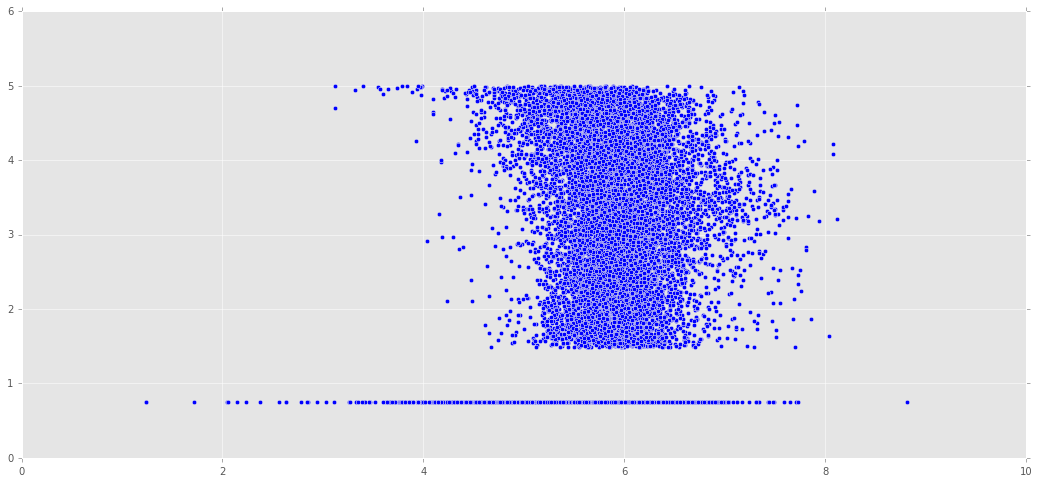

time: 392 ms


In [136]:
plt.scatter(np.log10(users.expenses / 13), users.FSI_score)

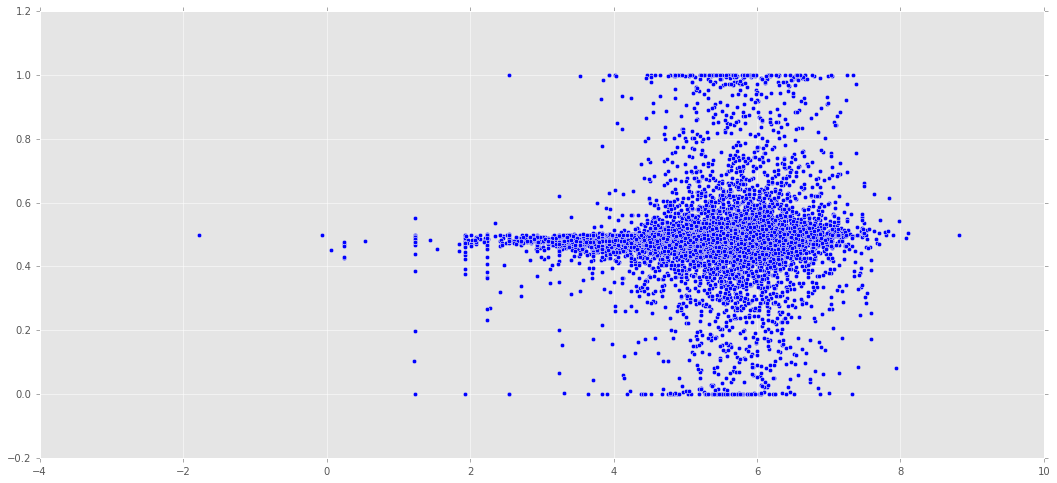

time: 386 ms


In [140]:
plt.scatter(np.log10(users.income / 13), users.sNWI)

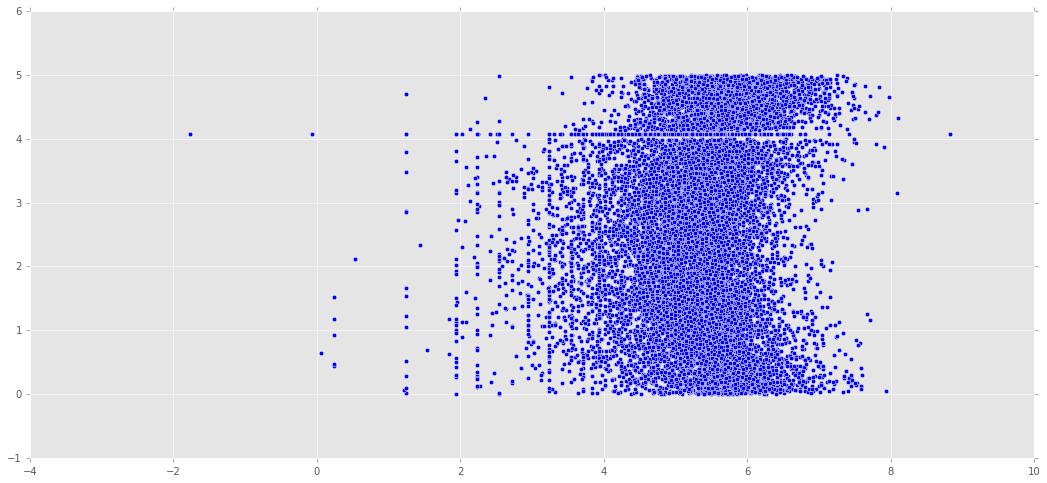

time: 430 ms


In [141]:
plt.scatter(np.log10(users.income / 13), users.NWI_score)

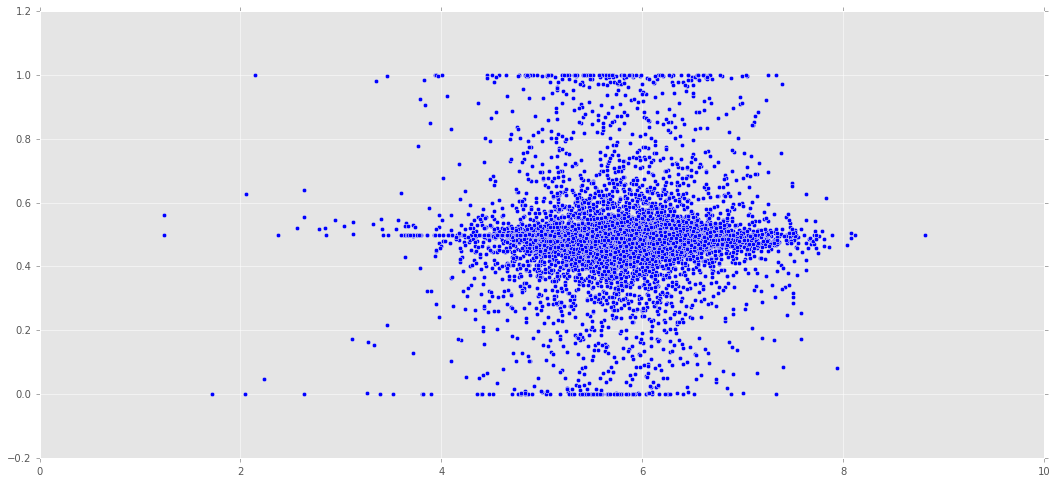

time: 375 ms


In [143]:
plt.scatter(np.log10(users.expenses / 13), users.sNWI)

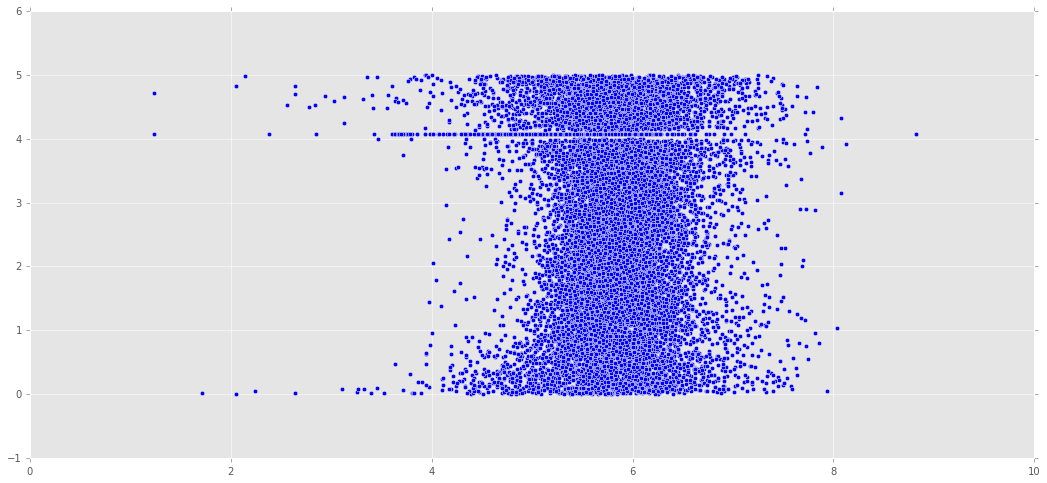

time: 403 ms


In [142]:
plt.scatter(np.log10(users.expenses / 13), users.NWI_score)

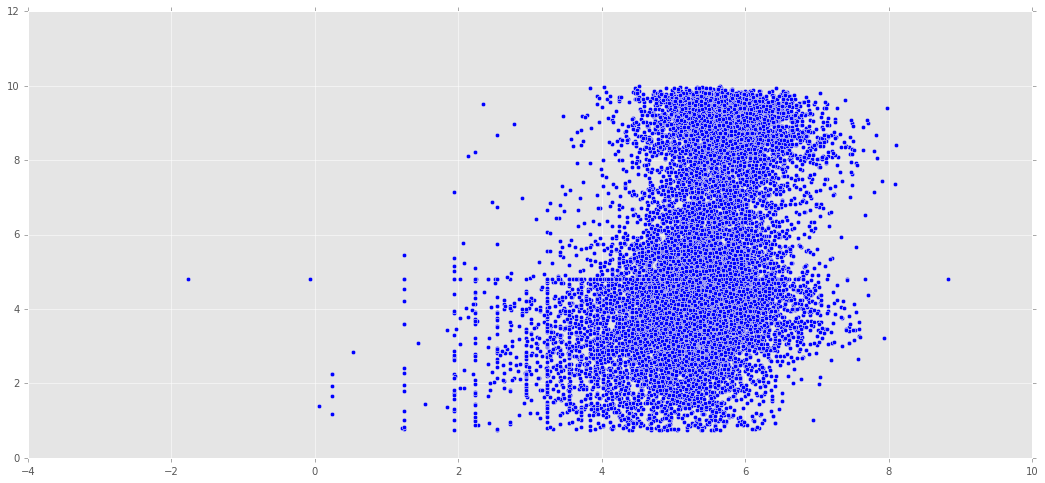

time: 396 ms


In [144]:
plt.scatter(np.log10(users.income / 13), users.FHI)

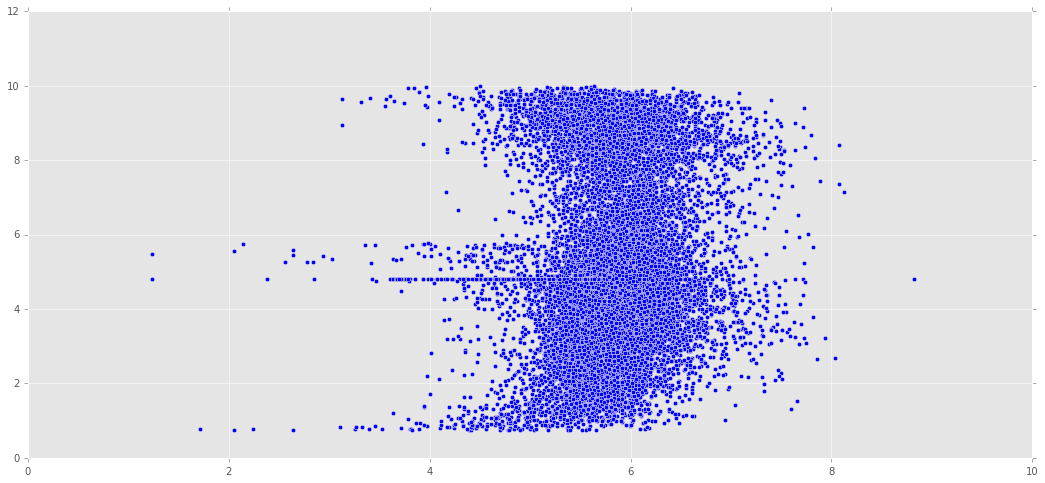

time: 396 ms


In [145]:
plt.scatter(np.log10(users.expenses / 13), users.FHI)

In [148]:
mcc_codes = pd.DataFrame.from_csv('../data/tr_mcc_codes.csv', sep=';')
mcc_codes.head()

,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплосна..."
1731,Подрядчики по электричеству
1799,"Подрядчики, специализированная торговля — нигд..."
2741,Разнообразные издательства/печатное дело


time: 7.37 ms


In [146]:
expenses = test_transactions.query('is_income == 0')

time: 287 ms


In [149]:
expenses\
    .groupby('mcc_code')['reg_coeff']\
    .agg(['count', 'mean'])\
    .query('count > 100')\
    .sort_values('mean')\
    .join(mcc_codes)\
    .sort_values('mean', ascending=False)\
    [['mean', 'mcc_description']]
#     .query('reg_coeff > 0')\

,mean,mcc_description
mcc_code,,
6011,0.535903,Финансовые институты — снятие наличности автом...
4814,0.530759,"Звонки с использованием телефонов, считывающих..."
5411,0.403614,"Бакалейные магазины, супермаркеты"
4829,0.282522,Денежные переводы
5499,0.215969,"Различные продовольственные магазины — рынки, ..."
5912,0.213445,Аптеки
5541,0.160332,Станции техобслуживания
5331,0.127001,Универсальные магазины
5814,0.113424,"Рестораны, закусочные"


time: 73.2 ms


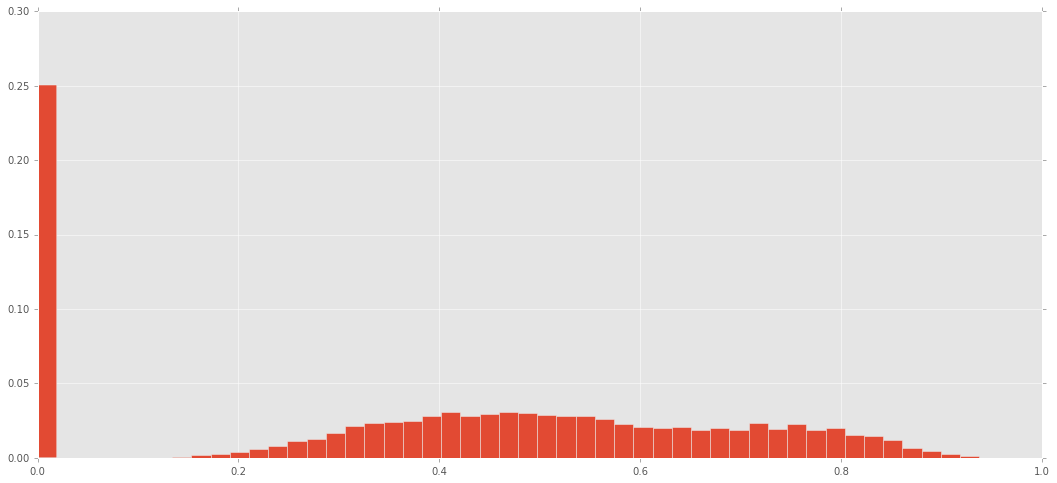

time: 420 ms


In [150]:
ds = expenses.query('mcc_code == 5411').reg_coeff
weights = np.ones_like(ds) / float(len(ds))
ds.hist(bins=50, weights=weights)

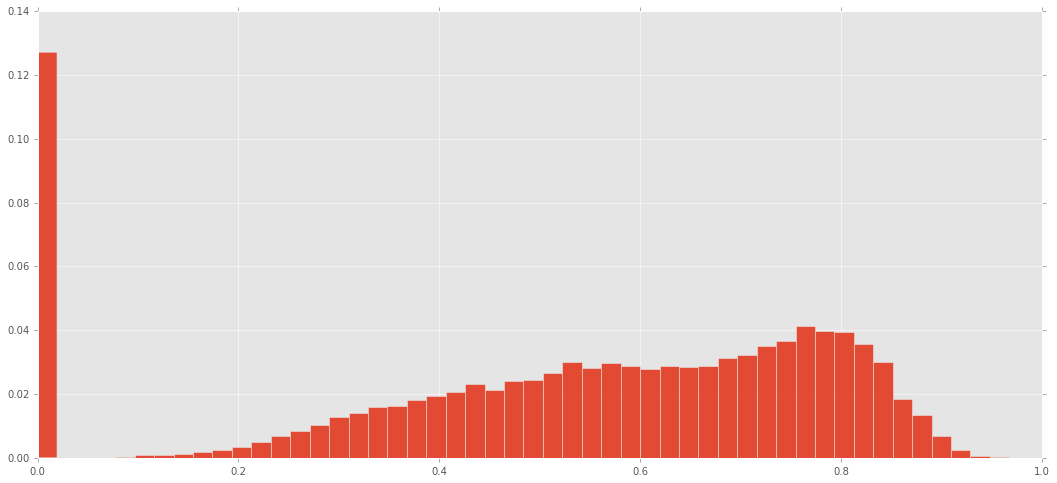

time: 511 ms


In [152]:
ds = expenses.query('mcc_code == 4814').reg_coeff
weights = np.ones_like(ds) / float(len(ds))
ds.hist(bins=50, weights=weights)

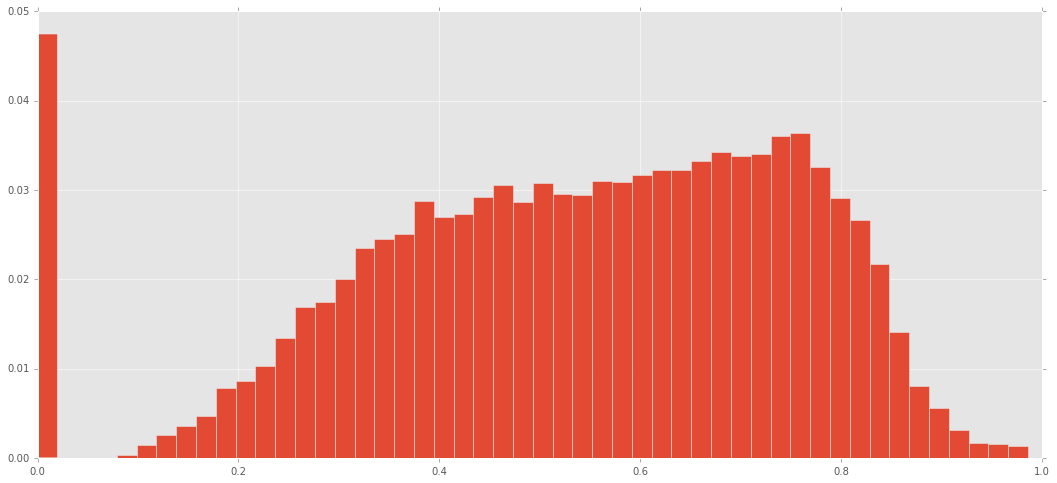

time: 425 ms


In [151]:
ds = expenses.query('mcc_code == 6011').reg_coeff
weights = np.ones_like(ds) / float(len(ds))
ds.hist(bins=50, weights=weights)